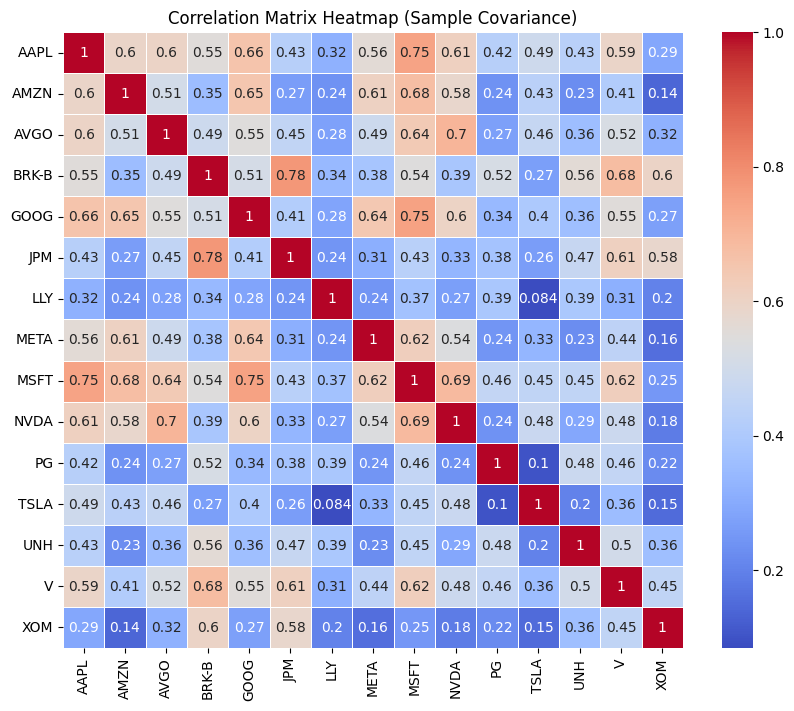

<Figure size 640x480 with 0 Axes>

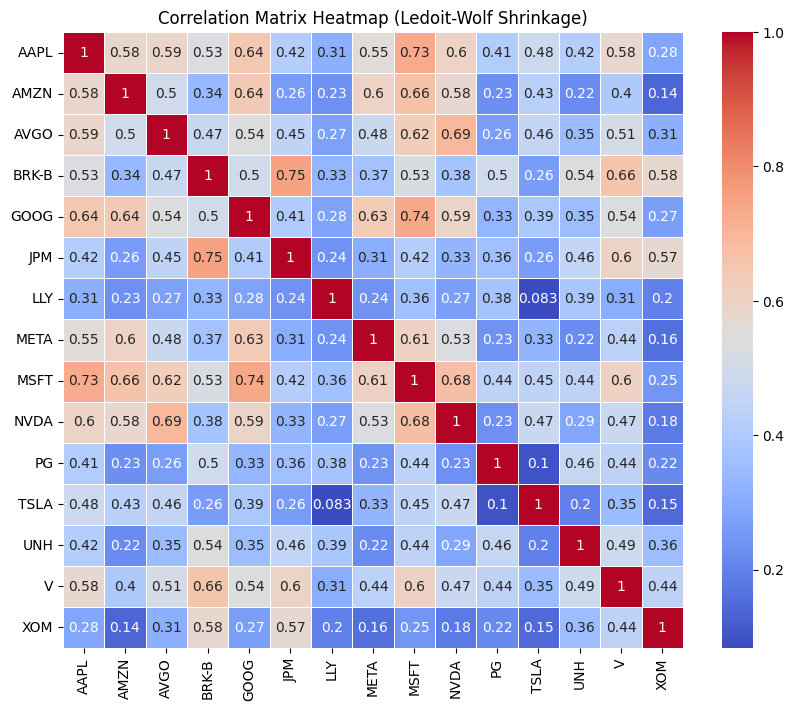

<Figure size 640x480 with 0 Axes>

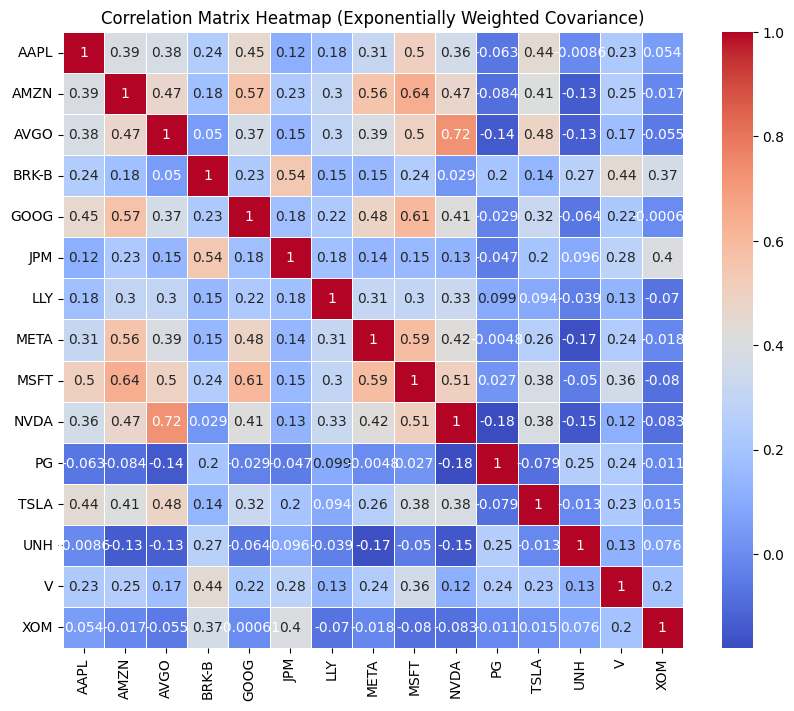

<Figure size 640x480 with 0 Axes>

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier

# Load prices
prices = pd.read_csv('adjust_close.csv')

# Set the 'date' column as the index
prices.set_index('date', inplace=True)

# Calculate daily percentage changes
returns = prices.pct_change(fill_method=None)
returns.dropna(inplace=True)

# Calculate covariance matrices using different methods
cov_matrix = returns.cov() * 252 
cov_pfopt = risk_models.sample_cov(prices, frequency=252)
cov_ledoit = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
cov_exp = risk_models.exp_cov(prices, frequency=252, span=252, log_returns=True)

# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)
    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    return corr_matrix

corr_cov_pfopt = calculate_correlation(cov_pfopt)
corr_cov_ledoit = calculate_correlation(cov_ledoit)
corr_cov_exp = calculate_correlation(cov_exp)

# Plotting the correlation matrices as heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_pfopt, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Sample Covariance)')
plt.show()
plt.savefig('correlation_heatmap.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
plt.show()
plt.savefig('correlation_heatmap_ledoit.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_exp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Exponentially Weighted Covariance)')
plt.show()
plt.savefig('correlation_heatmap_exp.png')





In [110]:
risk = risk_models.risk_matrix(prices, method='exp_cov')
# print (risk)

capm_returns = expected_returns.ema_historical_return(prices)
print(capm_returns)
historic_returns = expected_returns.mean_historical_return(prices)
print(historic_returns)

max_weight = (1 / len(prices.columns)) * 2
# print(max_weight)

# Standard MVO, optimised for Sharpe Ratio
ef = EfficientFrontier(capm_returns, cov_matrix, weight_bounds=(0.01, max_weight))
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)
ef.portfolio_performance(verbose=True)

# Standard MVO, optimised for Sharpe Ratio
ef = EfficientFrontier(historic_returns, cov_matrix, weight_bounds=(0.01, max_weight))
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)
ef.portfolio_performance(verbose=True)

# MVO, optimised for minimum volatility
efmin = EfficientFrontier(capm_returns, cov_matrix, weight_bounds=(0.01, max_weight))
efmin.min_volatility()
weights = efmin.clean_weights()
print(weights)
efmin.portfolio_performance(verbose=True)





AAPL     0.315467
AMZN     0.311153
AVGO     0.952106
BRK-B    0.266529
GOOG     0.246542
JPM      0.321412
LLY      0.630876
META     0.786199
MSFT     0.253738
NVDA     1.639902
PG       0.158708
TSLA     0.495411
UNH      0.205165
V        0.134885
XOM      0.187086
Name: 2024-09-27, dtype: float64
AAPL     0.333631
AMZN     0.167558
AVGO     0.487959
BRK-B    0.171156
GOOG     0.222011
JPM      0.157094
LLY      0.532463
META     0.262265
MSFT     0.264444
NVDA     0.950848
PG       0.095957
TSLA     0.748185
UNH      0.236362
V        0.106528
XOM      0.160201
dtype: float64
OrderedDict({'AAPL': 0.01, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13333, 'GOOG': 0.01, 'JPM': 0.07777, 'LLY': 0.13333, 'META': 0.13333, 'MSFT': 0.01, 'NVDA': 0.13333, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.02576, 'V': 0.01, 'XOM': 0.03647})
Expected annual return: 64.6%
Annual volatility: 24.2%
Sharpe Ratio: 2.59
OrderedDict({'AAPL': 0.02897, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13333, 'GOOG': 0.01, 'J

(0.30179661619495585, 0.1975211605138317, 1.426665454282923)

In [106]:
import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier


# Load prices
prices = pd.read_csv('adjust_close.csv')

# Set the 'date' column as the index
prices.set_index('date', inplace=True)

# Calculate daily percentage changes and annualized expected returns
returns = prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(prices)  
cov_matrix = risk_models.sample_cov(prices)           

# Other variables

risk_free_rate = 0.02
assets = len(prices.columns)
max_weight = (1 / assets) * 2
weight_equal = round(1 / assets, 5)



# Helper function to calculate Sortino ratio
def calculate_sortino_ratio(returns, weights, target_return=0.0):
    portfolio_returns = np.dot(returns, weights)
    downside_risk = np.sqrt(np.mean(np.minimum(portfolio_returns - target_return, 0) ** 2))
    annualized_return = np.sum(returns.mean() * weights) * 252
    return (annualized_return - target_return) / downside_risk if downside_risk != 0 else np.nan

# 1. Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
equal_weight_dict = {ticker: weight_equal for ticker in prices.columns}
print(equal_weight_dict)

# equal weights ratios
ew_return = np.dot(ew, mu)
ew_vol = np.sqrt(np.dot(ew.T, np.dot(cov_matrix, ew)))
ew_sharpe = (ew_return - risk_free_rate) / ew_vol
ew_sortino = calculate_sortino_ratio(returns, ew)

print(f"Equal Weighted Portfolio:")
print(f"Expected Return: {ew_return:.2%}")
print(f"Volatility: {ew_vol:.2%}")
print(f"Sharpe Ratio: {ew_sharpe:.2f}")
print(f"Sortino Ratio: {ew_sortino:.2f}")

# 2. Max Sharpe Ratio Portfolio
ef = EfficientFrontier(mu, cov_matrix, weight_bounds=(0.01, max_weight))
ef.max_sharpe(risk_free_rate=risk_free_rate)
max_sharpe_weights = ef.clean_weights()
max_sharpe_weights = {ticker: round(weight, 5) for ticker, weight in max_sharpe_weights.items()}
print(f"Max Sharpe Portfolio:")
print(max_sharpe_weights)
max_sharpe_performance = ef.portfolio_performance(verbose=True)

# 3. Minimum Volatility Portfolio
ef = EfficientFrontier(mu, cov_matrix, weight_bounds=(0.01, max_weight))
ef.min_volatility()
min_vol_weights = ef.clean_weights()
min_vol_weights = {ticker: round(weight, 5) for ticker, weight in min_vol_weights.items()}
print(f"Minimum Vol Portfolio:")
print(min_vol_weights)
min_vol_performance = ef.portfolio_performance(verbose=True)

# 






# Combine into pandas dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weight (%)')
max_sharpe_series = pd.Series(max_sharpe_weights, name='Max Sharpe Weight (%)')
min_vol_series = pd.Series(min_vol_weights, name='Minimum Vol Weight (%)')
weights_df = pd.concat([ew_series, max_sharpe_series, min_vol_series], axis=1)
print(weights_df)






{'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667}
Equal Weighted Portfolio:
Expected Return: 32.64%
Volatility: 24.03%
Sharpe Ratio: 1.28
Sortino Ratio: 31.97
Max Sharpe Portfolio:
{'AAPL': 0.02897, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13333, 'GOOG': 0.01, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.13333, 'PG': 0.09029, 'TSLA': 0.13333, 'UNH': 0.13333, 'V': 0.01, 'XOM': 0.02074}
Expected annual return: 45.0%
Annual volatility: 25.7%
Sharpe Ratio: 1.68
Minimum Vol Portfolio:
{'AAPL': 0.01, 'AMZN': 0.12665, 'AVGO': 0.01, 'BRK-B': 0.13333, 'GOOG': 0.02862, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.01, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.13333, 'V': 0.10807, 'XOM': 0.13333}
Expected annual return: 23.1%
Annual volatility: 19.8%
Sharpe Ratio